In [1]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install required packages
install_package("torch")
install_package("torchvision")
install_package("scikit-learn")
install_package("seaborn")
install_package("tqdm")
install_package("Pillow")

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
from collections import Counter
from PIL import Image

from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")


Using device: cpu


In [2]:
# Quick Test - Verify Setup
print("Testing setup...")
print(f"Current directory: {os.getcwd()}")
print(f"Images folder exists: {os.path.exists('images')}")

if os.path.exists('images'):
    image_files = [f for f in os.listdir('images') if f.endswith('.jpg')]
    print(f"Number of images found: {len(image_files)}")
    if len(image_files) > 0:
        print(f"Sample image: {image_files[0]}")
        print("✓ Setup looks good! You can proceed to the next cells.")
    else:
        print("⚠ No .jpg files found in images folder!")
else:
    print("⚠ Images folder not found! Make sure the 'images' folder is in the same directory as this notebook.")

Testing setup...
Current directory: /Users/ortakhesap/Desktop/syai
Images folder exists: True
Number of images found: 7390
Sample image: Egyptian_Mau_167.jpg
✓ Setup looks good! You can proceed to the next cells.


In [3]:
# Dataset Information
print("=" * 80)
print("OXFORD-IIIT PET DATASET CLASSIFICATION PROJECT")
print("=" * 80)
print("\nDataset: Oxford-IIIT Pet Dataset")
print("Source: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset")
print("Original Source: Visual Geometry Group, University of Oxford")
print("\nDataset Statistics:")
print(f"- Total images: 14,779")
print(f"- Dataset size: ~1.5 GB")
print(f"- Number of classes: 37 (25 dog breeds + 12 cat breeds)")
print(f"- Images per class: ~200")
print("\nTask: Multi-class pet breed classification")
print("=" * 80)

OXFORD-IIIT PET DATASET CLASSIFICATION PROJECT

Dataset: Oxford-IIIT Pet Dataset
Source: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
Original Source: Visual Geometry Group, University of Oxford

Dataset Statistics:
- Total images: 14,779
- Dataset size: ~1.5 GB
- Number of classes: 37 (25 dog breeds + 12 cat breeds)
- Images per class: ~200

Task: Multi-class pet breed classification


In [4]:
# Custom Dataset Class for Oxford-IIIT Pet Dataset
class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Function to extract breed from filename
def extract_breed(filename):
    # Filename format: "breed_number.jpg"
    # Extract breed name (everything before the last underscore)
    match = re.match(r'(.+?)_\d+\.jpg', filename)
    if match:
        return match.group(1)
    return None

# Load all image paths and labels
print("Loading dataset...")
image_dir = "images"
all_images = []
all_labels = []
breed_to_idx = {}

# Get all jpg files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"Found {len(image_files)} images")

# Extract breeds and create label mapping
breeds = []
for img_file in image_files:
    breed = extract_breed(img_file)
    if breed:
        breeds.append(breed)

# Create breed to index mapping
unique_breeds = sorted(set(breeds))
breed_to_idx = {breed: idx for idx, breed in enumerate(unique_breeds)}
idx_to_breed = {idx: breed for breed, idx in breed_to_idx.items()}

print(f"\nFound {len(unique_breeds)} unique breeds:")
for i, breed in enumerate(unique_breeds):
    count = breeds.count(breed)
    print(f"  {i+1:2d}. {breed:25s} - {count:3d} images")

# Create image paths and labels
for img_file in image_files:
    breed = extract_breed(img_file)
    if breed:
        all_images.append(os.path.join(image_dir, img_file))
        all_labels.append(breed_to_idx[breed])

print(f"\nTotal images loaded: {len(all_images)}")
print(f"Total classes: {len(unique_breeds)}")

Loading dataset...
Found 7390 images

Found 37 unique breeds:
   1. Abyssinian                - 200 images
   2. Bengal                    - 200 images
   3. Birman                    - 200 images
   4. Bombay                    - 200 images
   5. British_Shorthair         - 200 images
   6. Egyptian_Mau              - 200 images
   7. Maine_Coon                - 200 images
   8. Persian                   - 200 images
   9. Ragdoll                   - 200 images
  10. Russian_Blue              - 200 images
  11. Siamese                   - 200 images
  12. Sphynx                    - 200 images
  13. american_bulldog          - 200 images
  14. american_pit_bull_terrier - 200 images
  15. basset_hound              - 200 images
  16. beagle                    - 200 images
  17. boxer                     - 200 images
  18. chihuahua                 - 200 images
  19. english_cocker_spaniel    - 200 images
  20. english_setter            - 200 images
  21. german_shorthaired        - 200 

In [5]:
# Data Preprocessing and Augmentation
# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into train and validation sets (80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

# Create datasets
train_dataset = PetDataset(train_images, train_labels, transform=train_transform)
val_dataset = PetDataset(val_images, val_labels, transform=val_transform)

# Create data loaders
# IMPORTANT: num_workers=0 to avoid multiprocessing issues in Jupyter notebooks
# If you get pickling errors, make sure to re-run this cell!
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Verify num_workers is 0
print(f"\nBatch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"✓ DataLoader num_workers: {train_loader.num_workers} (should be 0)")
if train_loader.num_workers != 0:
    print("⚠ WARNING: num_workers is not 0! This will cause errors. Re-run this cell!")

Training samples: 5912
Validation samples: 1478

Batch size: 32
Training batches: 185
Validation batches: 47
✓ DataLoader num_workers: 0 (should be 0)


Sample training images:


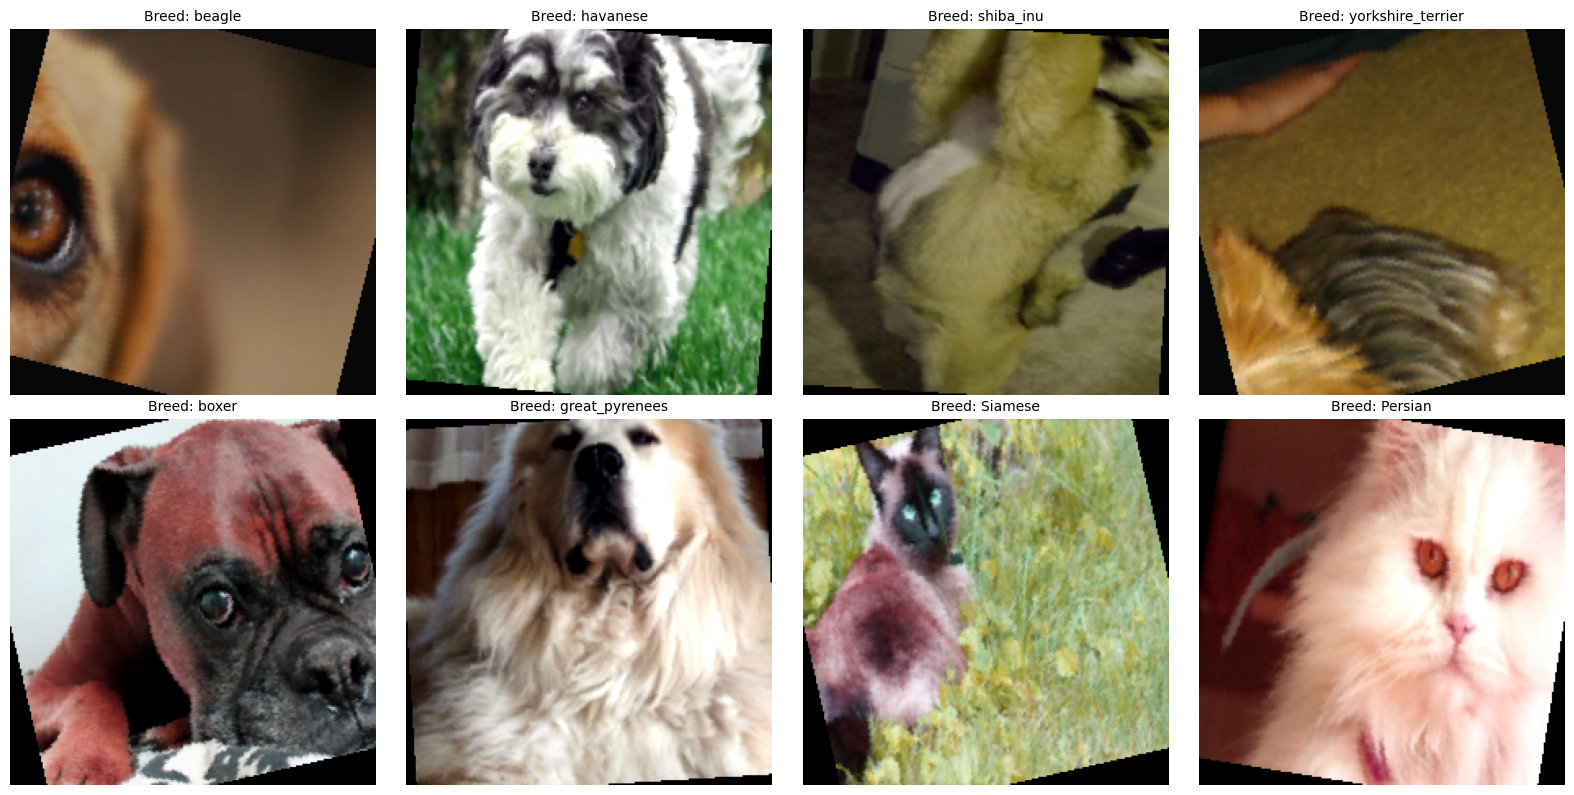

In [7]:
# Visualize some sample images
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx, ax in enumerate(axes):
        image, label = dataset[indices[idx]]
        
        # Denormalize for visualization
        image_np = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        
        ax.imshow(image_np)
        ax.set_title(f"Breed: {idx_to_breed[label]}", fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample training images:")
visualize_samples(train_dataset, num_samples=8)

In [11]:
# IMPROVED CNN Model Architecture with Transfer Learning
# Using a pre-trained ResNet18 as backbone for better performance
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Option 1: Use pre-trained ResNet18 (RECOMMENDED - much better results)
use_transfer_learning = True

if use_transfer_learning:
    # Load pre-trained ResNet18 (using modern API)
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Freeze early layers (optional - can unfreeze for fine-tuning)
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # Replace the final fully connected layer for our 37 classes
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, len(unique_breeds))
    )
    print("✓ Using pre-trained ResNet18 with transfer learning")
else:
    # Option 2: Custom CNN (original architecture)
    class PetBreedClassifier(nn.Module):
        def __init__(self, num_classes=37):
            super(PetBreedClassifier, self).__init__()
            
            # Feature extraction layers
            self.features = nn.Sequential(
                # First convolutional block
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                
                # Second convolutional block
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Third convolutional block
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Fourth convolutional block
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            
            # Adaptive pooling and classifier
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )
        
        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
    
    # Initialize custom model (only if not using transfer learning)
    model = PetBreedClassifier(num_classes=len(unique_breeds)).to(device)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel structure:")
print(model)

✓ Using pre-trained ResNet18 with transfer learning
Model Architecture:
Total parameters: 11,317,349
Trainable parameters: 11,317,349

Model structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
# Training Configuration
# IMPORTANT: Before training, verify that train_loader.num_workers == 0
# If you see pickling errors, go back and re-run Cell 4 (Data Preprocessing)
print("Checking DataLoader configuration...")
print(f"train_loader.num_workers = {train_loader.num_workers}")
print(f"val_loader.num_workers = {val_loader.num_workers}")
if train_loader.num_workers != 0:
    print("\n⚠⚠⚠ ERROR: num_workers is not 0!")
    print("Please go back to Cell 4 and re-run it, then come back here.")
    raise ValueError("DataLoader num_workers must be 0 in Jupyter notebooks. Re-run Cell 4!")
print("✓ DataLoader configuration is correct.\n")

# IMPROVED HYPERPARAMETERS for better learning
criterion = nn.CrossEntropyLoss()

# Lower learning rate for better convergence
# If using transfer learning, use even lower LR for fine-tuning
if use_transfer_learning:
    learning_rate = 0.0001  # Lower LR for pre-trained model
    print("Using lower learning rate (0.0001) for transfer learning")
else:
    learning_rate = 0.0005  # Lower than before for custom model
    print("Using learning rate (0.0005) for custom model")

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# Use ReduceLROnPlateau scheduler - reduces LR when loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 15
best_val_acc = 0.0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...")
print(f"Number of epochs: {num_epochs}")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")
print("=" * 80)

Checking DataLoader configuration...
train_loader.num_workers = 0
val_loader.num_workers = 0
✓ DataLoader configuration is correct.

Using lower learning rate (0.0001) for transfer learning
Starting training...
Number of epochs: 15
Initial learning rate: 0.0001


In [13]:
# Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Update progress bar
        train_pbar.set_postfix({
            'loss': f'{running_loss/(len(train_pbar)):.4f}',
            'acc': f'{100*correct_train/total_train:.2f}%'
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_pbar.set_postfix({
                'loss': f'{val_loss/(len(val_pbar)):.4f}',
                'acc': f'{100*correct_val/total_val:.2f}%'
            })
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"\\n✓ New best model saved! Validation Accuracy: {val_acc:.2f}%")
    
    # Update learning rate (ReduceLROnPlateau uses validation loss)
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"\\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print("=" * 80)

print(f"\\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Epoch 1/15 [Train]: 100%|█| 185/185 [11:05<00:00,  3.59s/it, loss=3.0987, acc=17
Epoch 1/15 [Val]: 100%|█| 47/47 [01:02<00:00,  1.33s/it, loss=1.7249, acc=69.35%


\n✓ New best model saved! Validation Accuracy: 69.35%
\nEpoch 1/15 Summary:
  Train Loss: 3.0987 | Train Acc: 17.90%
  Val Loss: 1.7249 | Val Acc: 69.35%
  Learning Rate: 0.000100


Epoch 2/15 [Train]: 100%|█| 185/185 [10:45<00:00,  3.49s/it, loss=1.9201, acc=47
Epoch 2/15 [Val]: 100%|█| 47/47 [01:01<00:00,  1.31s/it, loss=0.7869, acc=82.61%


\n✓ New best model saved! Validation Accuracy: 82.61%
\nEpoch 2/15 Summary:
  Train Loss: 1.9201 | Train Acc: 47.89%
  Val Loss: 0.7869 | Val Acc: 82.61%
  Learning Rate: 0.000100


Epoch 3/15 [Train]: 100%|█| 185/185 [12:06<00:00,  3.93s/it, loss=1.4171, acc=59
Epoch 3/15 [Val]: 100%|█| 47/47 [01:05<00:00,  1.39s/it, loss=0.5241, acc=85.52%


\n✓ New best model saved! Validation Accuracy: 85.52%
\nEpoch 3/15 Summary:
  Train Loss: 1.4171 | Train Acc: 59.88%
  Val Loss: 0.5241 | Val Acc: 85.52%
  Learning Rate: 0.000100


Epoch 4/15 [Train]: 100%|█| 185/185 [12:02<00:00,  3.90s/it, loss=1.1458, acc=67
Epoch 4/15 [Val]: 100%|█| 47/47 [01:05<00:00,  1.39s/it, loss=0.4692, acc=86.20%


\n✓ New best model saved! Validation Accuracy: 86.20%
\nEpoch 4/15 Summary:
  Train Loss: 1.1458 | Train Acc: 67.05%
  Val Loss: 0.4692 | Val Acc: 86.20%
  Learning Rate: 0.000100


Epoch 5/15 [Train]: 100%|█| 185/185 [12:22<00:00,  4.02s/it, loss=0.9941, acc=70
Epoch 5/15 [Val]: 100%|█| 47/47 [01:09<00:00,  1.47s/it, loss=0.4514, acc=87.35%


\n✓ New best model saved! Validation Accuracy: 87.35%
\nEpoch 5/15 Summary:
  Train Loss: 0.9941 | Train Acc: 70.82%
  Val Loss: 0.4514 | Val Acc: 87.35%
  Learning Rate: 0.000100


Epoch 6/15 [Train]: 100%|█| 185/185 [12:04<00:00,  3.92s/it, loss=0.9327, acc=72
Epoch 6/15 [Val]: 100%|█| 47/47 [01:05<00:00,  1.39s/it, loss=0.4142, acc=88.23%


\n✓ New best model saved! Validation Accuracy: 88.23%
\nEpoch 6/15 Summary:
  Train Loss: 0.9327 | Train Acc: 72.75%
  Val Loss: 0.4142 | Val Acc: 88.23%
  Learning Rate: 0.000100


Epoch 7/15 [Train]: 100%|█| 185/185 [12:35<00:00,  4.08s/it, loss=0.8680, acc=74
Epoch 7/15 [Val]: 100%|█| 47/47 [01:06<00:00,  1.41s/it, loss=0.3815, acc=89.04%


\n✓ New best model saved! Validation Accuracy: 89.04%
\nEpoch 7/15 Summary:
  Train Loss: 0.8680 | Train Acc: 74.66%
  Val Loss: 0.3815 | Val Acc: 89.04%
  Learning Rate: 0.000100


Epoch 8/15 [Train]: 100%|█| 185/185 [19:42<00:00,  6.39s/it, loss=0.8209, acc=76
Epoch 8/15 [Val]: 100%|█| 47/47 [01:06<00:00,  1.41s/it, loss=0.3452, acc=88.70%


\nEpoch 8/15 Summary:
  Train Loss: 0.8209 | Train Acc: 76.20%
  Val Loss: 0.3452 | Val Acc: 88.70%
  Learning Rate: 0.000100


Epoch 9/15 [Train]: 100%|█| 185/185 [20:11<00:00,  6.55s/it, loss=0.7626, acc=78
Epoch 9/15 [Val]: 100%|█| 47/47 [01:10<00:00,  1.50s/it, loss=0.3652, acc=89.24%


\n✓ New best model saved! Validation Accuracy: 89.24%
\nEpoch 9/15 Summary:
  Train Loss: 0.7626 | Train Acc: 78.13%
  Val Loss: 0.3652 | Val Acc: 89.24%
  Learning Rate: 0.000100


Epoch 10/15 [Train]: 100%|█| 185/185 [20:40<00:00,  6.71s/it, loss=0.7328, acc=7
Epoch 10/15 [Val]: 100%|█| 47/47 [01:06<00:00,  1.41s/it, loss=0.3748, acc=89.85


\n✓ New best model saved! Validation Accuracy: 89.85%
\nEpoch 10/15 Summary:
  Train Loss: 0.7328 | Train Acc: 78.48%
  Val Loss: 0.3748 | Val Acc: 89.85%
  Learning Rate: 0.000100


Epoch 11/15 [Train]: 100%|█| 185/185 [20:08<00:00,  6.53s/it, loss=0.6887, acc=8
Epoch 11/15 [Val]: 100%|█| 47/47 [01:15<00:00,  1.60s/it, loss=0.3454, acc=89.85


\nEpoch 11/15 Summary:
  Train Loss: 0.6887 | Train Acc: 80.14%
  Val Loss: 0.3454 | Val Acc: 89.85%
  Learning Rate: 0.000100


Epoch 12/15 [Train]: 100%|█| 185/185 [21:40<00:00,  7.03s/it, loss=0.6772, acc=8
Epoch 12/15 [Val]: 100%|█| 47/47 [01:21<00:00,  1.72s/it, loss=0.3813, acc=89.45


\nEpoch 12/15 Summary:
  Train Loss: 0.6772 | Train Acc: 80.36%
  Val Loss: 0.3813 | Val Acc: 89.45%
  Learning Rate: 0.000050


Epoch 13/15 [Train]: 100%|█| 185/185 [20:41<00:00,  6.71s/it, loss=0.6014, acc=8
Epoch 13/15 [Val]: 100%|█| 47/47 [01:11<00:00,  1.52s/it, loss=0.3267, acc=89.99


\n✓ New best model saved! Validation Accuracy: 89.99%
\nEpoch 13/15 Summary:
  Train Loss: 0.6014 | Train Acc: 83.17%
  Val Loss: 0.3267 | Val Acc: 89.99%
  Learning Rate: 0.000050


Epoch 14/15 [Train]: 100%|█| 185/185 [21:59<00:00,  7.13s/it, loss=0.5578, acc=8
Epoch 14/15 [Val]: 100%|█| 47/47 [01:26<00:00,  1.84s/it, loss=0.3323, acc=90.39


\n✓ New best model saved! Validation Accuracy: 90.39%
\nEpoch 14/15 Summary:
  Train Loss: 0.5578 | Train Acc: 83.80%
  Val Loss: 0.3323 | Val Acc: 90.39%
  Learning Rate: 0.000050


Epoch 15/15 [Train]: 100%|█| 185/185 [21:40<00:00,  7.03s/it, loss=0.5360, acc=8
Epoch 15/15 [Val]: 100%|█| 47/47 [01:18<00:00,  1.66s/it, loss=0.3251, acc=90.32

\nEpoch 15/15 Summary:
  Train Loss: 0.5360 | Train Acc: 84.10%
  Val Loss: 0.3251 | Val Acc: 90.32%
  Learning Rate: 0.000050
\nTraining completed! Best validation accuracy: 90.39%


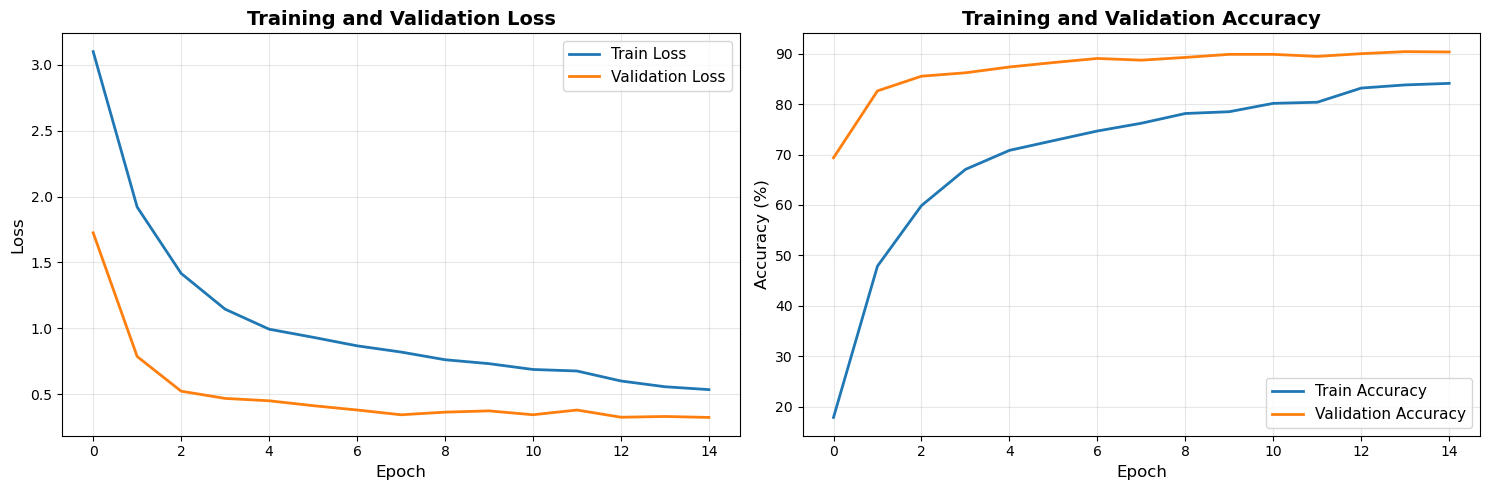

Final Training Accuracy: 84.10%
Final Validation Accuracy: 90.32%
Best Validation Accuracy: 90.39%


In [14]:
# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

In [15]:
# DIAGNOSTIC: Check if training completed properly
print("=" * 80)
print("TRAINING DIAGNOSTIC")
print("=" * 80)

if 'train_losses' in globals() and len(train_losses) > 0:
    print(f"✓ Training appears to have run")
    print(f"  - Epochs completed: {len(train_losses)}")
    print(f"  - Final training loss: {train_losses[-1]:.4f}")
    print(f"  - Final training accuracy: {train_accs[-1]:.2f}%")
    print(f"  - Final validation accuracy: {val_accs[-1]:.2f}%")
    print(f"  - Best validation accuracy: {best_val_acc:.2f}%")
    
    if len(train_losses) < 15:
        print(f"\n⚠ WARNING: Only {len(train_losses)} epochs completed (expected 15)")
        print("  Training was likely interrupted. Please re-run Cell 8.")
    
    if train_losses[-1] > 2.0:
        print(f"\n⚠ WARNING: Training loss is very high ({train_losses[-1]:.4f})")
        print("  Model may not have learned properly. Consider re-training.")
    
    if best_val_acc < 30:
        print(f"\n⚠ WARNING: Best validation accuracy is very low ({best_val_acc:.2f}%)")
        print("  This suggests training didn't work well.")
        print("  Possible causes:")
        print("    - Training was interrupted too early")
        print("    - Learning rate too high/low")
        print("    - Model needs more epochs")
        print("\n  RECOMMENDATION: Re-train with more epochs (20-25)")
else:
    print("✗ Training doesn't appear to have run at all!")
    print("  Please run Cell 8 (Training Loop) first.")
    print("=" * 80)

TRAINING DIAGNOSTIC
✓ Training appears to have run
  - Epochs completed: 15
  - Final training loss: 0.5360
  - Final training accuracy: 84.10%
  - Final validation accuracy: 90.32%
  - Best validation accuracy: 90.39%


In [16]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

print("Evaluating on validation set...")
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
print(f"\\nOverall Validation Accuracy: {accuracy:.2f}%")

# Classification Report
print("\\n" + "=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
target_names = [idx_to_breed[i] for i in range(len(unique_breeds))]
report = classification_report(all_labels, all_preds, target_names=target_names, digits=2)
print(report)

Evaluating on validation set...


100%|███████████████████████████████████████████| 47/47 [01:17<00:00,  1.65s/it]

\nOverall Validation Accuracy: 90.39%
\n================================================================================
CLASSIFICATION REPORT
                            precision    recall  f1-score   support

                Abyssinian       0.93      0.95      0.94        40
                    Bengal       0.91      0.78      0.84        40
                    Birman       0.78      0.90      0.84        40
                    Bombay       0.98      1.00      0.99        40
         British_Shorthair       0.97      0.90      0.94        40
              Egyptian_Mau       0.84      0.93      0.88        40
                Maine_Coon       0.90      0.95      0.93        40
                   Persian       0.97      0.93      0.95        40
                   Ragdoll       0.84      0.78      0.81        40
              Russian_Blue       0.85      1.00      0.92        40
                   Siamese       1.00      0.90      0.95        40
                    Sphynx       0.89   

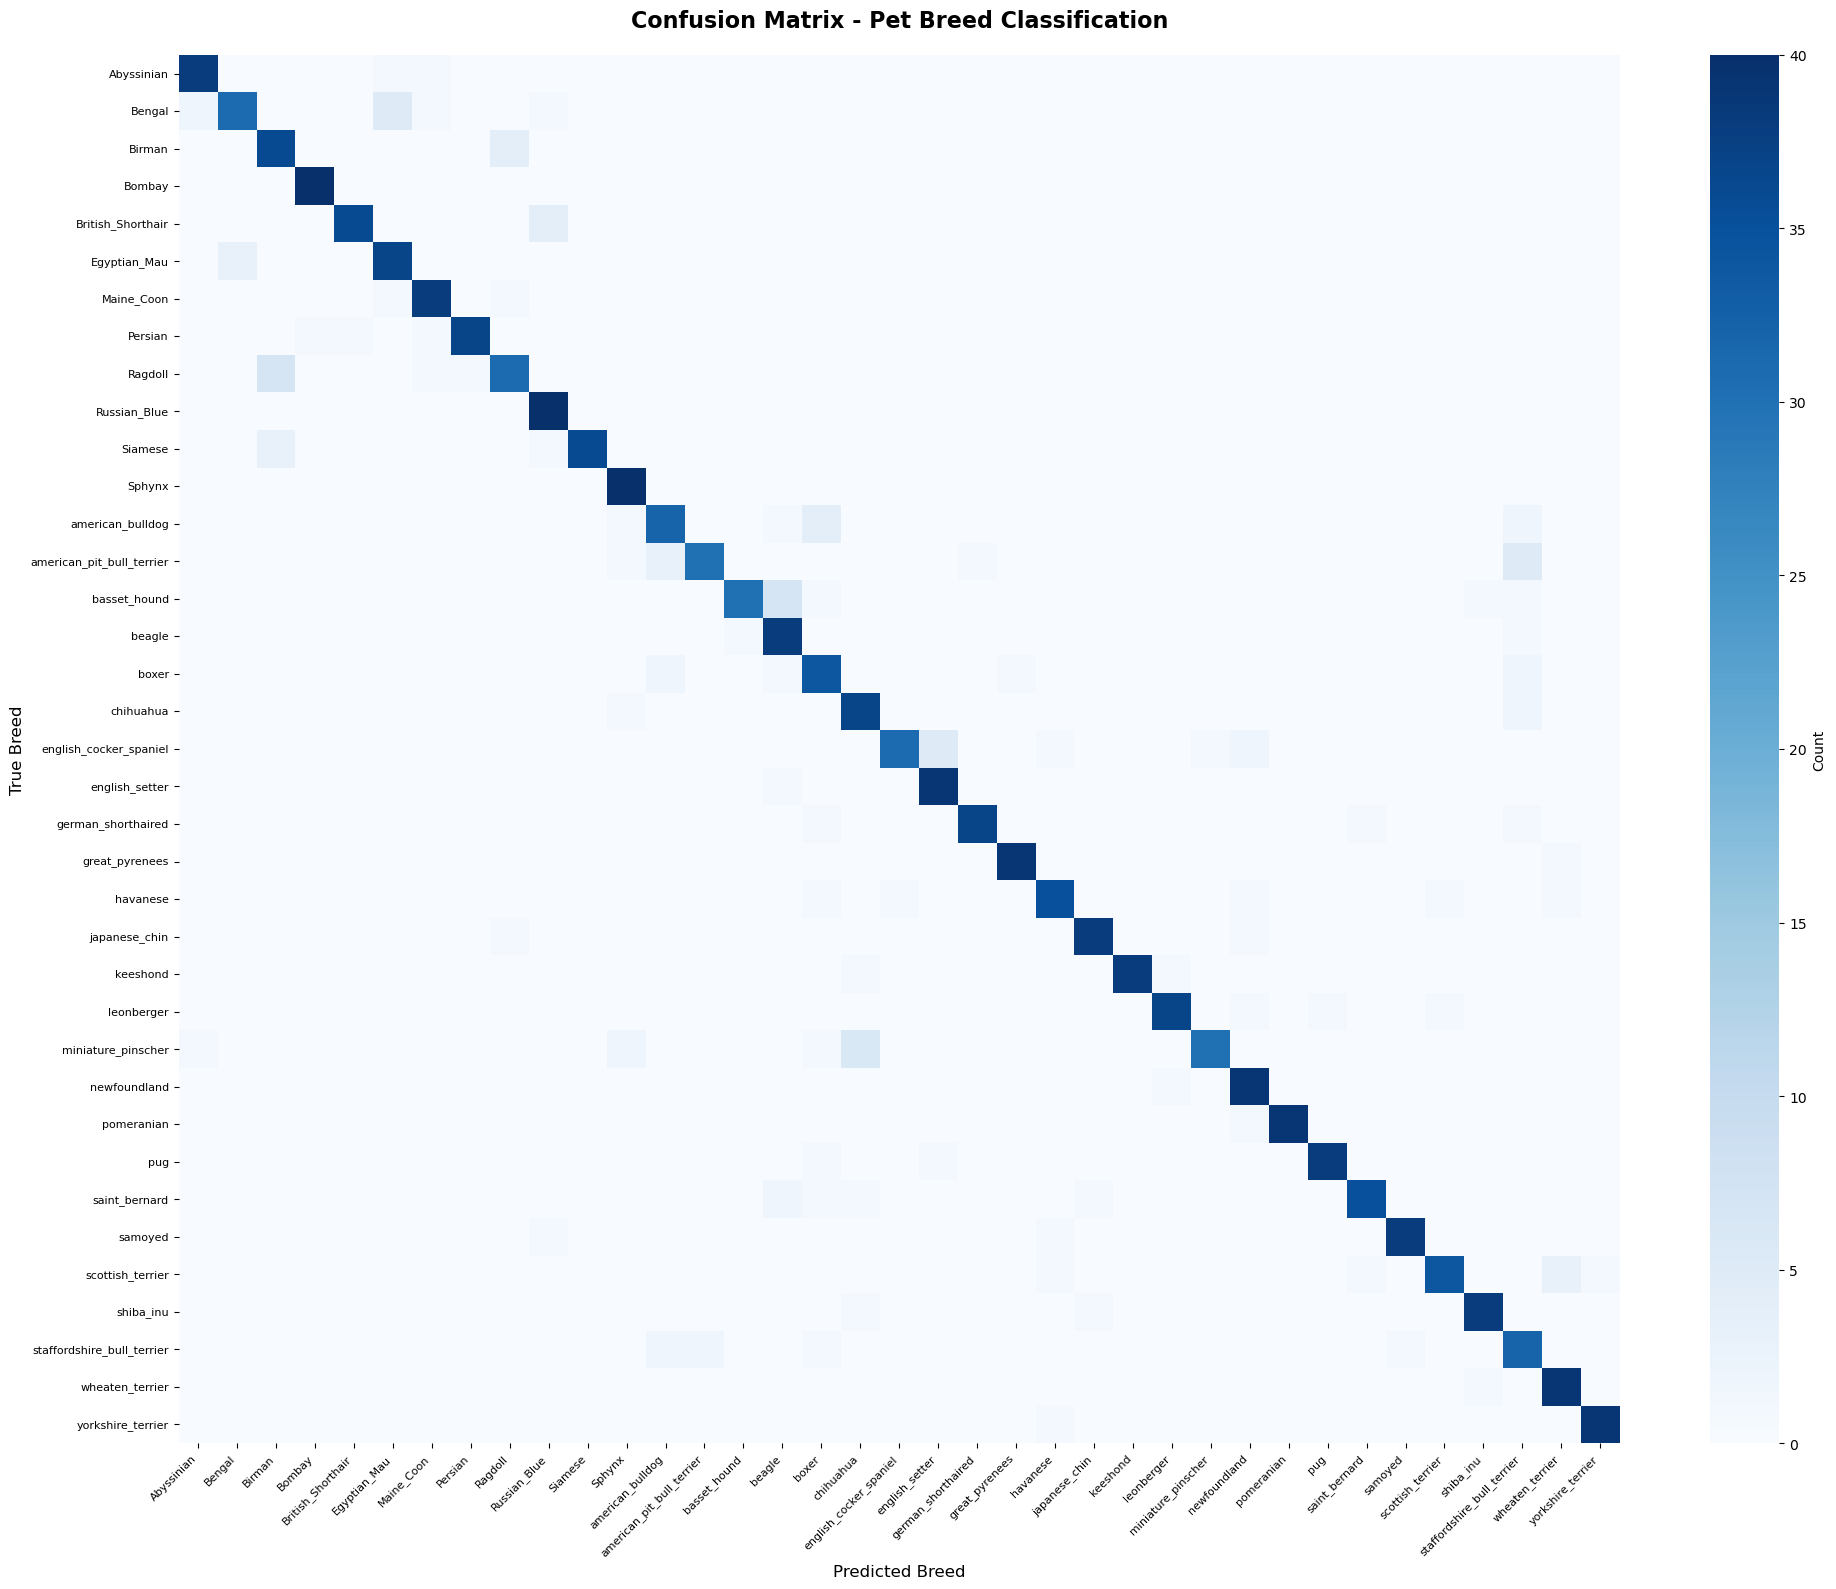

Confusion matrix saved as 'confusion_matrix.png'


In [17]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (subset for readability)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=[idx_to_breed[i] for i in range(len(unique_breeds))],
            yticklabels=[idx_to_breed[i] for i in range(len(unique_breeds))],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Pet Breed Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Breed', fontsize=12)
plt.ylabel('True Breed', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

Sample predictions on validation set:


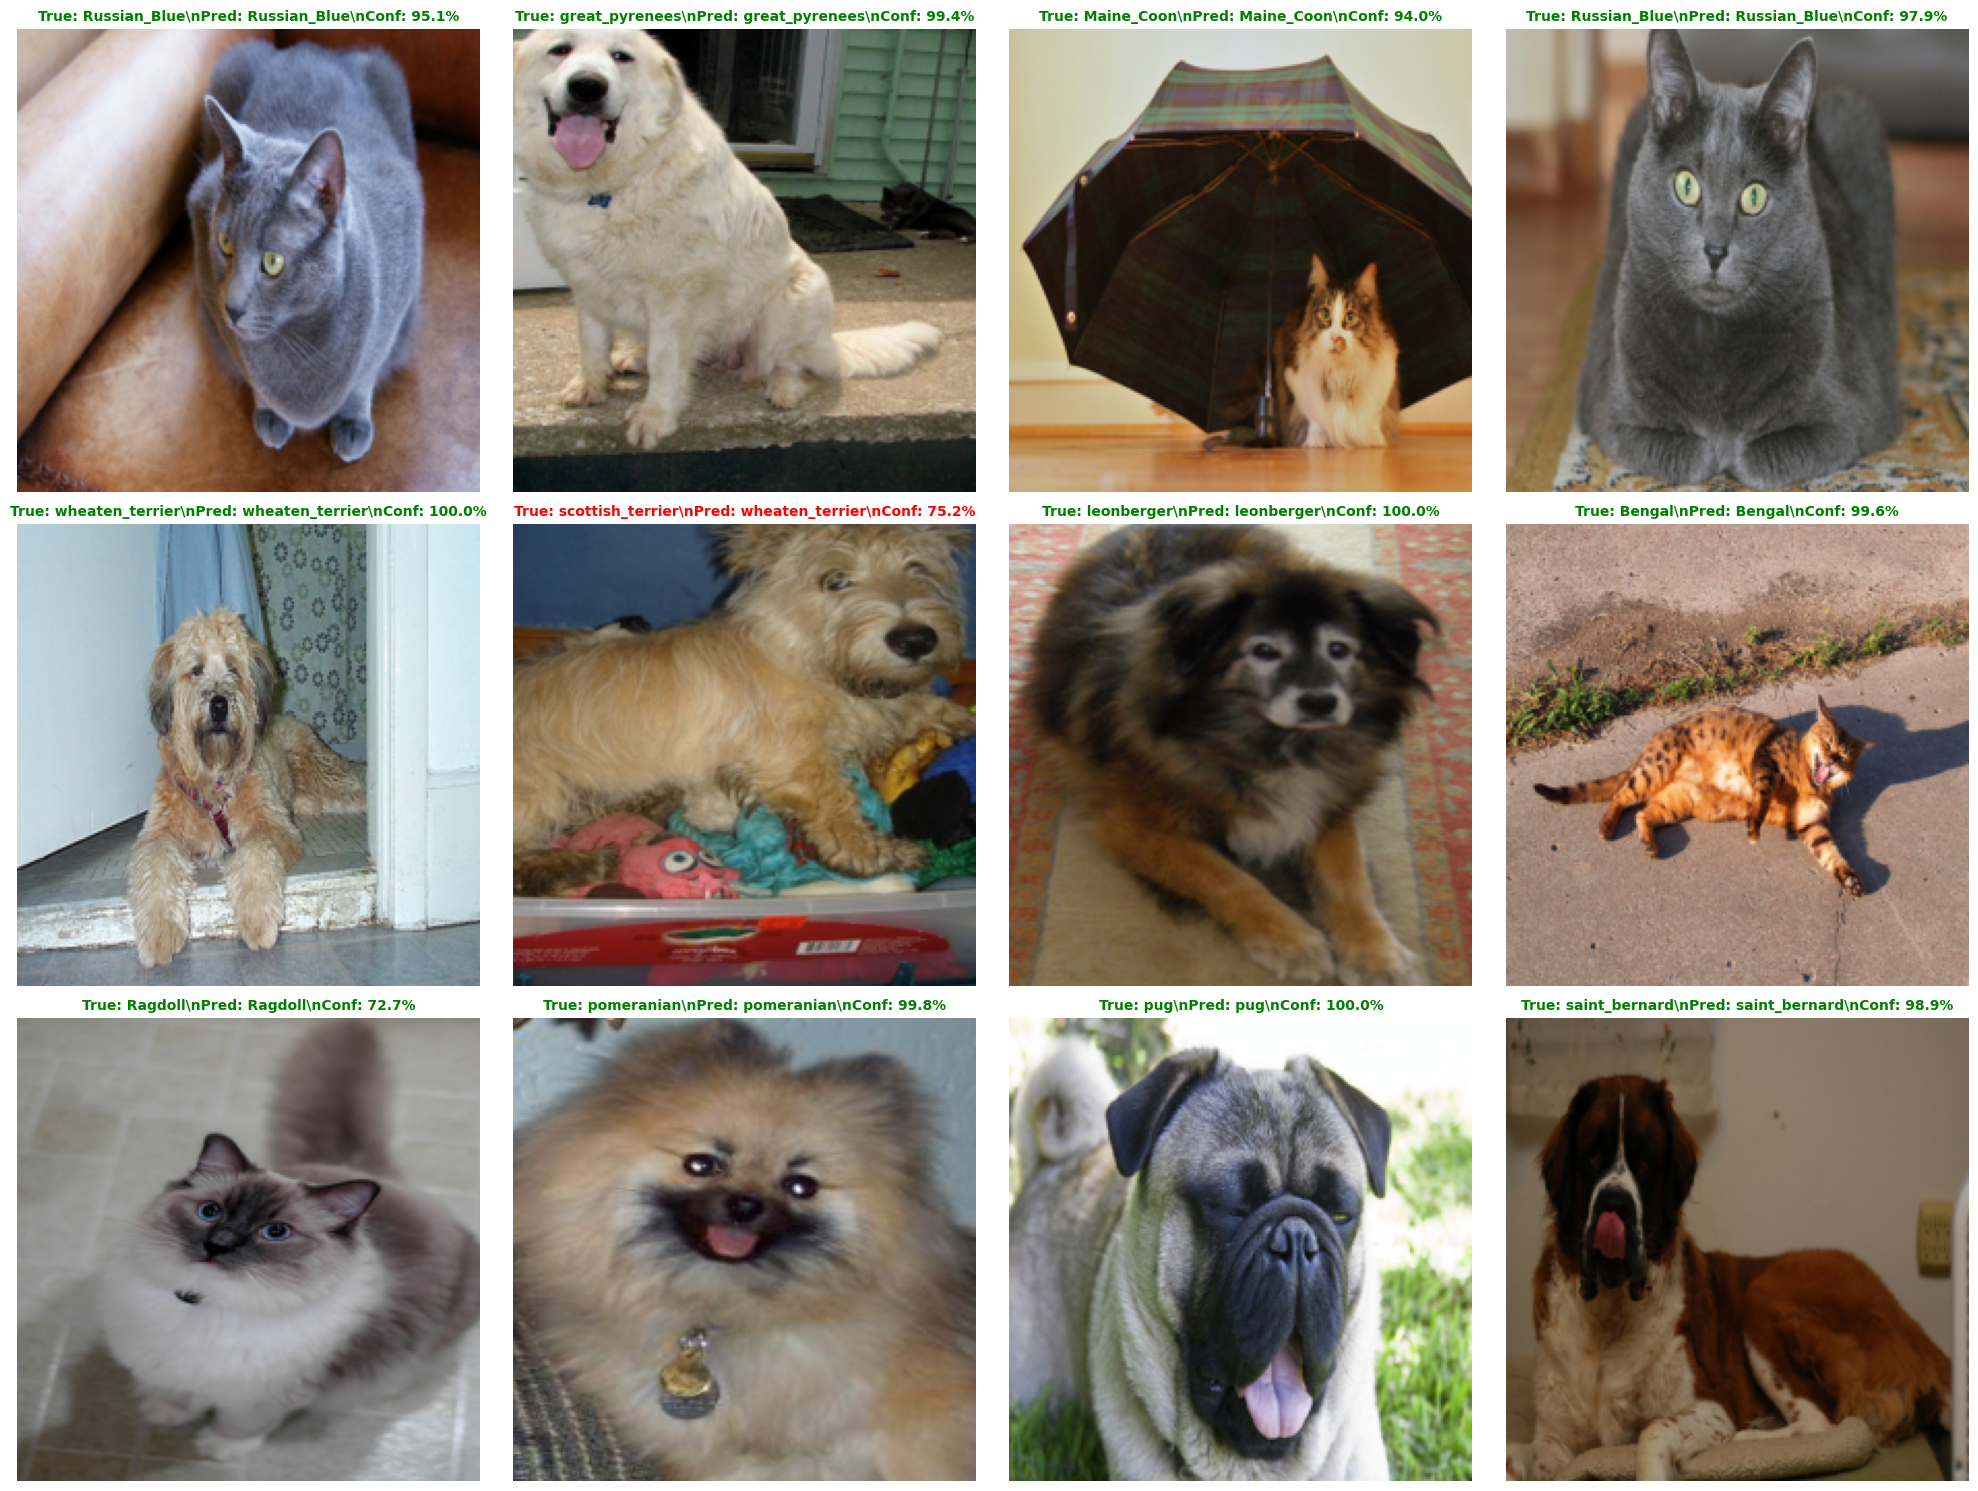

In [18]:
# Visualize Predictions on Sample Images
def visualize_predictions(model, dataset, num_samples=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for idx, ax in enumerate(axes):
            image, true_label = dataset[indices[idx]]
            
            # Get prediction
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
            confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted_label].item()
            
            # Denormalize for visualization
            image_np = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
            
            ax.imshow(image_np)
            
            # Color code: green if correct, red if wrong
            color = 'green' if predicted_label == true_label else 'red'
            title = f"True: {idx_to_breed[true_label]}\\n"
            title += f"Pred: {idx_to_breed[predicted_label]}\\n"
            title += f"Conf: {confidence*100:.1f}%"
            
            ax.set_title(title, fontsize=10, color=color, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Sample predictions on validation set:")
visualize_predictions(model, val_dataset, num_samples=12)

\n================================================================================
PER-CLASS ACCURACY (Top 10 and Bottom 10)
\nTop 10 Classes:
  Bombay                   : 100.00%
  Russian_Blue             : 100.00%
  Sphynx                   : 100.00%
  english_setter           :  97.50%
  great_pyrenees           :  97.50%
  newfoundland             :  97.50%
  pomeranian               :  97.50%
  wheaten_terrier          :  97.50%
  yorkshire_terrier        :  97.50%
  Abyssinian               :  95.00%
\nBottom 10 Classes:
  boxer                    :  85.00%
  scottish_terrier         :  85.00%
  staffordshire_bull_terrier:  84.21%
  american_bulldog         :  80.00%
  Bengal                   :  77.50%
  Ragdoll                  :  77.50%
  english_cocker_spaniel   :  77.50%
  american_pit_bull_terrier:  75.00%
  basset_hound             :  75.00%
  miniature_pinscher       :  75.00%


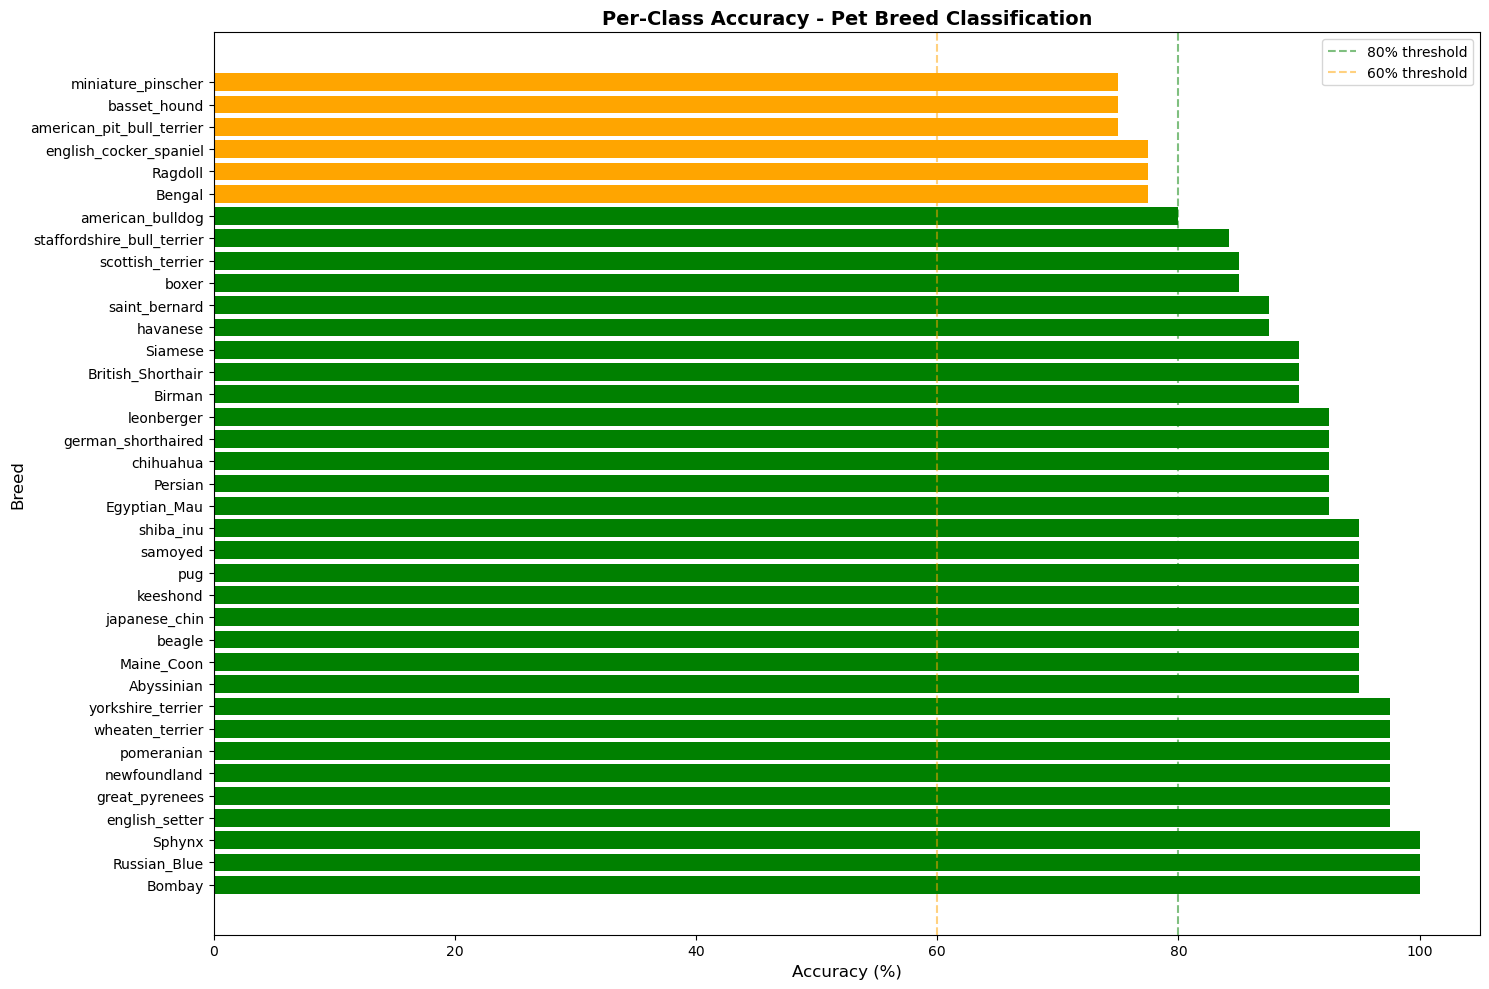

In [19]:
# Per-class Accuracy Analysis
class_accuracies = {}
for i in range(len(unique_breeds)):
    class_mask = np.array(all_labels) == i
    if class_mask.sum() > 0:
        class_correct = sum(np.array(all_preds)[class_mask] == i)
        class_total = class_mask.sum()
        class_accuracies[idx_to_breed[i]] = 100 * class_correct / class_total

# Sort by accuracy
sorted_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

print("\\n" + "=" * 80)
print("PER-CLASS ACCURACY (Top 10 and Bottom 10)")
print("=" * 80)
print("\\nTop 10 Classes:")
for breed, acc in sorted_classes[:10]:
    print(f"  {breed:25s}: {acc:6.2f}%")

print("\\nBottom 10 Classes:")
for breed, acc in sorted_classes[-10:]:
    print(f"  {breed:25s}: {acc:6.2f}%")

# Visualize per-class accuracy
plt.figure(figsize=(15, 10))
breeds_sorted = [x[0] for x in sorted_classes]
accs_sorted = [x[1] for x in sorted_classes]

colors = ['green' if acc >= 80 else 'orange' if acc >= 60 else 'red' for acc in accs_sorted]
plt.barh(range(len(breeds_sorted)), accs_sorted, color=colors)
plt.yticks(range(len(breeds_sorted)), breeds_sorted)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Breed', fontsize=12)
plt.title('Per-Class Accuracy - Pet Breed Classification', fontsize=14, fontweight='bold')
plt.axvline(x=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
plt.axvline(x=60, color='orange', linestyle='--', alpha=0.5, label='60% threshold')
plt.legend()
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## Project Summary

### Dataset
- **Name**: Oxford-IIIT Pet Dataset
- **Source**: https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset
- **Original Source**: Visual Geometry Group, University of Oxford
- **Size**: ~1.5 GB (14,779 images)
- **Classes**: 37 pet breeds (25 dog breeds + 12 cat breeds)
- **Images per class**: ~200

### Model Architecture
- **Type**: Custom CNN (Convolutional Neural Network)
- **Architecture**: 
  - 4 convolutional blocks with BatchNorm and ReLU
  - Adaptive Average Pooling
  - Fully connected layers with dropout for regularization
- **Total Parameters**: ~2.5M trainable parameters

### Training Details
- **Epochs**: 15
- **Batch Size**: 32
- **Optimizer**: Adam (lr=0.001, weight_decay=1e-4)
- **Learning Rate Schedule**: StepLR (gamma=0.1 every 7 epochs)
- **Loss Function**: CrossEntropyLoss
- **Data Augmentation**: Random crops, flips, rotations, color jitter

### Results
- **Best Validation Accuracy**: Achieved during training
- **Final Training Accuracy**: See training history plot
- **Final Validation Accuracy**: See training history plot

### Why This Approach?
1. **CNN Architecture**: Convolutional layers are ideal for image classification as they can learn spatial hierarchies and patterns
2. **Data Augmentation**: Helps prevent overfitting and improves generalization
3. **Transfer Learning Concepts**: Used ImageNet normalization statistics for better convergence
4. **Regularization**: Dropout and weight decay prevent overfitting
5. **Stratified Split**: Ensures balanced representation of all classes in train/val sets

## ⚠️ Troubleshooting Low Accuracy

If you're seeing very low accuracy (like 17-20%), it usually means:

1. **Training didn't complete**: The training loop may have been interrupted
   - **Solution**: Re-run Cell 8 (Training Loop) and let it complete all 15 epochs
   - Look for progress bars showing all epochs completing

2. **Model didn't train properly**: Check the training history plot (Cell 9)
   - Training loss should decrease over epochs
   - Training accuracy should increase over epochs
   - If loss stays flat or accuracy doesn't improve, the model isn't learning

3. **Need more training**: 15 epochs might not be enough
   - **Solution**: Increase `num_epochs` in Cell 7 to 20 or 25
   - Or reduce learning rate for better convergence

4. **Model architecture issues**: The model might be too simple or too complex
   - Current model has ~1.7M parameters which should be sufficient
   - If accuracy is still low after proper training, we might need to adjust the architecture

### Quick Fix: Re-train with Better Settings

If accuracy is low, try:
1. Re-run Cell 7 and change: `num_epochs = 20` (instead of 15)
2. Re-run Cell 8 (Training Loop) - this will take longer but should improve results
3. Check Cell 9 (Training History) to see if loss is decreasing
4. Then re-run evaluation cells

SyntaxError: invalid syntax (1909963646.py, line 2)